## Fitting examples for right and wrong predicted system class

In [78]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

%matplotlib inline
from util import *

import xrsdkit
xrsdkit.models.load_models('../xrsdkit_modeling/flowreactor_pd_nanoparticles/models')
from xrsdkit.models.predict import system_from_prediction, predict
from xrsdkit.system import fit, System
from xrsdkit.models import get_regression_models, get_classification_models
from xrsdkit.visualization import plot_xrsd_fit, draw_xrsd_fit

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_ind = pandas.read_csv("dataset_index.csv")
data = pandas.read_csv("main_classifier_results.csv")
data = data.merge(data_ind[['sample_id','yml_file','data_file' ]], left_on='sample_id', right_on='sample_id')
data.head()

,Unnamed: 0,experiment_id,sample_id,system_class,system_class_pr,diffuse_binary,disordered_binary,crystalline_binary,diffuse_binary_pr,disordered_binary_pr,crystalline_binary_pr,yml_file,data_file
0,221,R0_201811,R0_201811_1541372847,diffuse,diffuse__diffuse,True,False,False,True,False,False,gridsearch22_xrsd_system.yml,gridsearch22_dz_bgsub.dat
1,226,R0_201811,R0_201811_1541451179,diffuse,diffuse,True,False,False,True,False,False,gridsearch33_xrsd_system.yml,gridsearch33_dz_bgsub.dat
2,235,R0_201811,R0_201811_1541312605,diffuse,diffuse__diffuse,True,False,False,True,False,False,gridsearch11_xrsd_system.yml,gridsearch11_dz_bgsub.dat
3,244,R0_201811,R0_201811_1541366472,diffuse,unidentified,True,False,False,False,False,False,gridsearch20_xrsd_system.yml,gridsearch20_dz_bgsub.dat
4,232,R0_201811,R0_201811_1541364785,diffuse__diffuse,diffuse__diffuse,True,False,False,True,False,False,gridsearch19_xrsd_system.yml,gridsearch19_dz_bgsub.dat


### Predict form factor and all parameters given system class

In [80]:
error = []
form_factor = []
form_factor_pr = []
right_pred_ff = []

for index, row in data.iterrows():
    sys_cl_predicted = row['system_class_pr']
    exp = row['experiment_id']
    dat_file_name = row['data_file']
    yml_file_name = row['yml_file']
    yml_path = '../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + exp + '/' + yml_file_name
    with open(yml_path, 'r') as stream:
        data_loaded = yaml.safe_load(stream)
    features = data_loaded['features']
    f = open('../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + exp + '/' + dat_file_name,'r')
    q_I = np.loadtxt(f,dtype=float)
    pred = predict(features, sys_cl_predicted)
    sys_est = system_from_prediction(pred,q_I[: , 0],q_I[ :, 1],
            features = features,
            sample_metadata = data_loaded['sample_metadata'],
            fit_report = data_loaded['fit_report'])
    
    # save predicted system:
    dir_for_sample = "predicted/" + exp
    if not os.path.exists(dir_for_sample):
        os.makedirs(dir_for_sample)
    yml_path = dir_for_sample+ '/'+row['yml_file'] 
    with open(yml_path, 'w') as outfile:
        yaml.dump(sys_est.to_dict(), outfile)
    
    if q_I.shape[1] > 2:
        dI = q_I[:,2]
    else:
        dI = None
    sys_est = fit(sys_est,q_I[: , 0],q_I[ :, 1],dI=dI)
    error.append(sys_est.fit_report['final_objective'])
    
    all_true_pops = row['system_class'].split("__")
    all_true_forms = dict.fromkeys(all_true_pops)
    for k, v in all_true_forms.items():
        all_true_forms[k] = set()
        for k2, v2 in data_loaded.items():
            if 'structure' in v2 and v2['structure'] == k:
                all_true_forms[k].add(v2['form'])
    form_factor.append(all_true_forms)    
    
    all_pr_pops = row['system_class_pr'].split("__")
    all_pr_forms = dict.fromkeys(all_pr_pops)
    for k, v in all_pr_forms.items():
        all_pr_forms[k] = set()
        for k2, v2 in sys_est.to_dict().items():
            if 'structure' in v2 and v2['structure'] == k:
                all_pr_forms[k].add(v2['form'])
    form_factor_pr.append(all_pr_forms)
    
    # compare predicted and real set form factors:
    result = True
    if len(all_pr_forms)!= len(all_true_forms):
        result = False
    else:
        if set(all_pr_forms.keys())!= set(all_true_forms.keys()):
            result = False
        else:
            for k, v in all_true_forms.items():
                if v != all_pr_forms[k]:
                    result = False
    right_pred_ff.append(result)

In [10]:
data['error'] = error 
data['form_factor'] = form_factor
data['form_factor_pr'] = form_factor_pr
data['right_pred_ff'] = right_pred_ff

In [11]:
data['right_pred_sc']  = data.system_class == data.system_class_pr 

In [14]:
data['right_pred']  = (data.right_pred_sc &  data.right_pred_ff)

In [16]:
data.to_csv("data_with_error.csv")

In [17]:
data = pandas.read_csv("data_with_error.csv")

In [18]:
data.groupby(['system_class', 'right_pred']).size()

system_class                  right_pred
diffuse                       False          71
                              True            2
diffuse__diffuse              False          21
                              True          126
diffuse__diffuse__disordered  False          29
diffuse__disordered           False           2
                              True            5
unidentified                  False           3
                              True           34
dtype: int64

For each system class we want to visualize: 

* a samples with right predicted system_class and the smallest fitting error 
* a samples with right predicted system_class and the largest fitting error 
* a samples with wrong predicted system_class and the smallest fitting error 
* a samples with wrong predicted system_class and the largest fitting error

In [19]:
most_interesting_samples = {}
sample_ids = []

sys_classes = data.groupby(['system_class'])
for name, sc in sys_classes:
    most_interesting_samples[name] = {}
    t_f = sc.groupby(['right_pred'])
    for name2, l in t_f:
        most_interesting_samples[name][name2] = {}
        if len(l) > 0:
            max_error_sample = l.loc[l['error'].idxmax()]
            sample_ids.append((max_error_sample['system_class_pr'], max_error_sample['experiment_id'],
                               max_error_sample['sample_id'],max_error_sample['data_file'],
                               max_error_sample['yml_file']))
            most_interesting_samples[name][name2]['max_error_sample'] = max_error_sample
            min_error_sample = l.loc[l['error'].idxmin()]
            sample_ids.append((min_error_sample['system_class_pr'],min_error_sample['experiment_id'],
                               min_error_sample['sample_id'],min_error_sample['data_file'],
                               min_error_sample['yml_file']))
            most_interesting_samples[name][name2]['min_error_sample'] = min_error_sample 

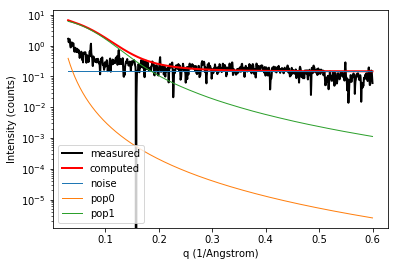

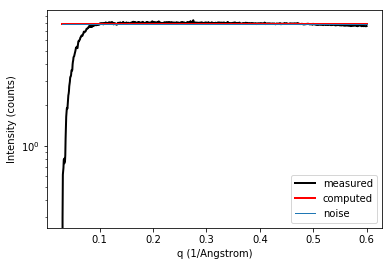

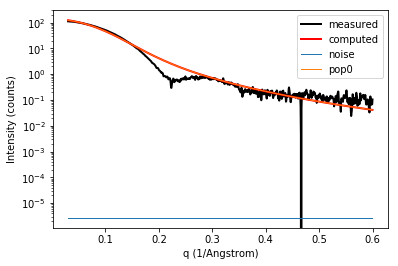

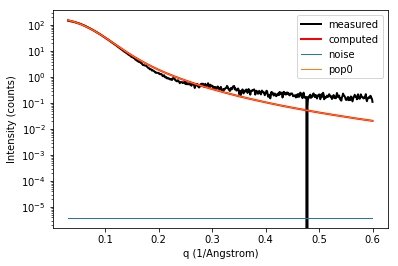

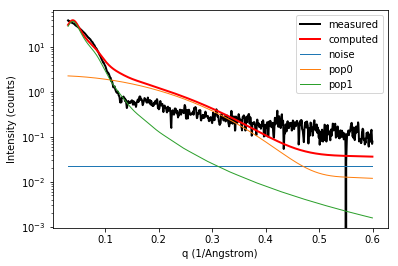

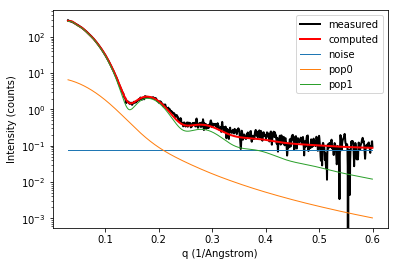

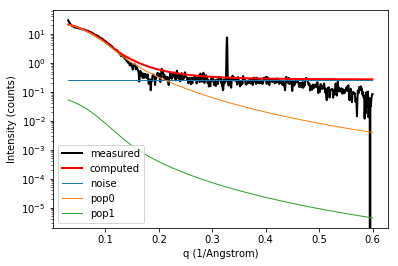

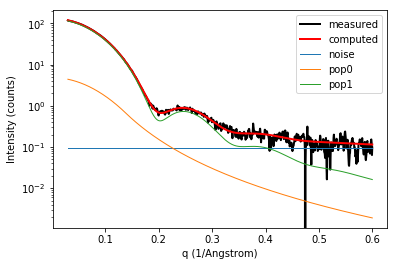

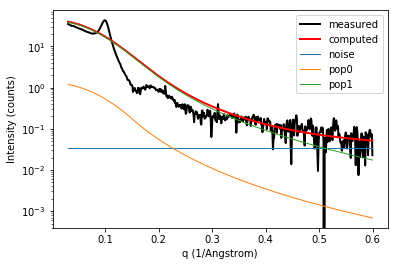

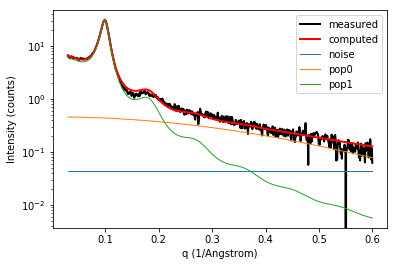

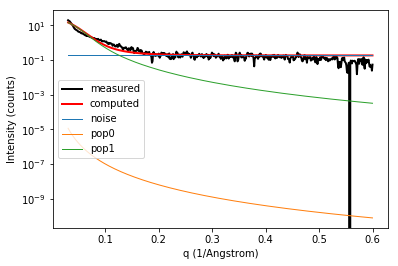

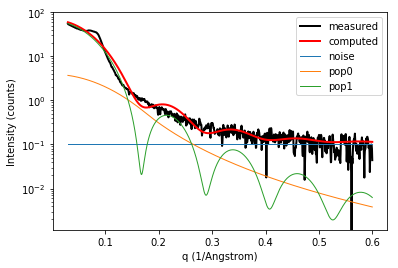

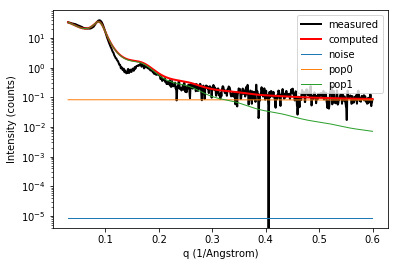

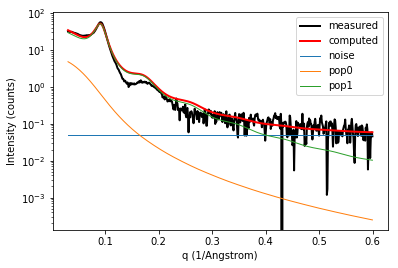

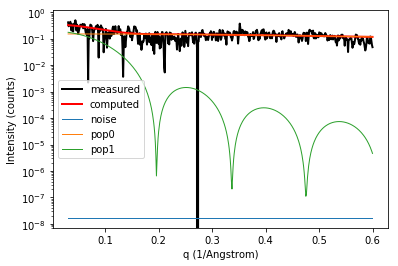

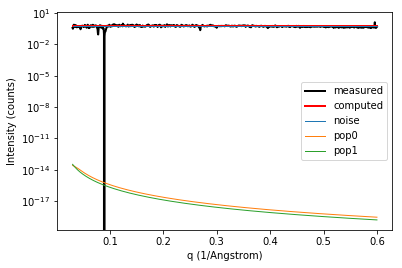

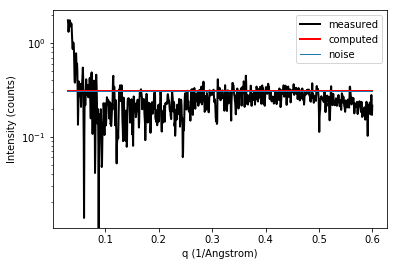

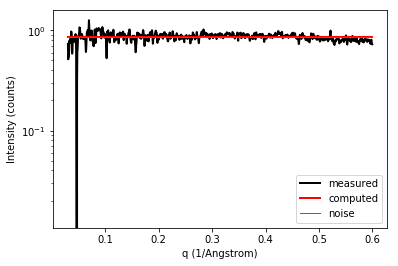

In [53]:
#predict system for each of these samples and save it in a yml file
for s in sample_ids:
    yml_path = '../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + s[1] + '/' + s[4]
    with open(yml_path, 'r') as stream:
        data_loaded = yaml.safe_load(stream)
    features = data_loaded['features']
    f = open('../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + s[1] + '/' + s[3],'r')
    q_I = np.loadtxt(f,dtype=float)
    pred = predict(features, s[0])
    sys_est = system_from_prediction(pred,q_I[: , 0],q_I[ :, 1],
            features = features,
            sample_metadata = data_loaded['sample_metadata'],
            fit_report = data_loaded['fit_report'])
    if q_I.shape[1] > 2:
        dI = q_I[:,2]
    else:
        dI = None
    sys_est = fit(sys_est,q_I[: , 0],q_I[ :, 1],dI=dI)
    yml_path = 'predicted_systems/'+ s[2] + '.yml'
    with open(yml_path, 'w') as outfile:
        yaml.dump(sys_est.to_dict(), outfile)
    # create figure and save it 
    pl, _ = plot_xrsd_fit(sys=sys_est, q=q_I[:,0], I=q_I[:, 1], dI=None, show_plot=False)
    fig_path = 'figures/'+ s[2] + '.png' #'.pdf'
    plt.savefig(fig_path)

In [54]:
ids = [x[2] for x in sample_ids]

In [55]:
samples_to_vis = data.loc[data['sample_id'].isin(ids)]

In [56]:
samples_to_vis = samples_to_vis[["experiment_id", "sample_id", "system_class", "system_class_pr", "yml_file","data_file", "error",
                                 'form_factor','form_factor_pr','right_pred']]

### Visualization of this samples

In [57]:
#import pprint
def helper(row):
    yml = "predicted_systems/" + row['sample_id'] + ".yml"
    d = yaml.load(open(yml))
    #pprint.pprint(d)
    dat = '../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + row['experiment_id'] + '/' + row['data_file']
    f = open(dat,'r')
    q_I = np.loadtxt(f,dtype=float)
    sys = System.from_dict(d)
    return q_I, sys

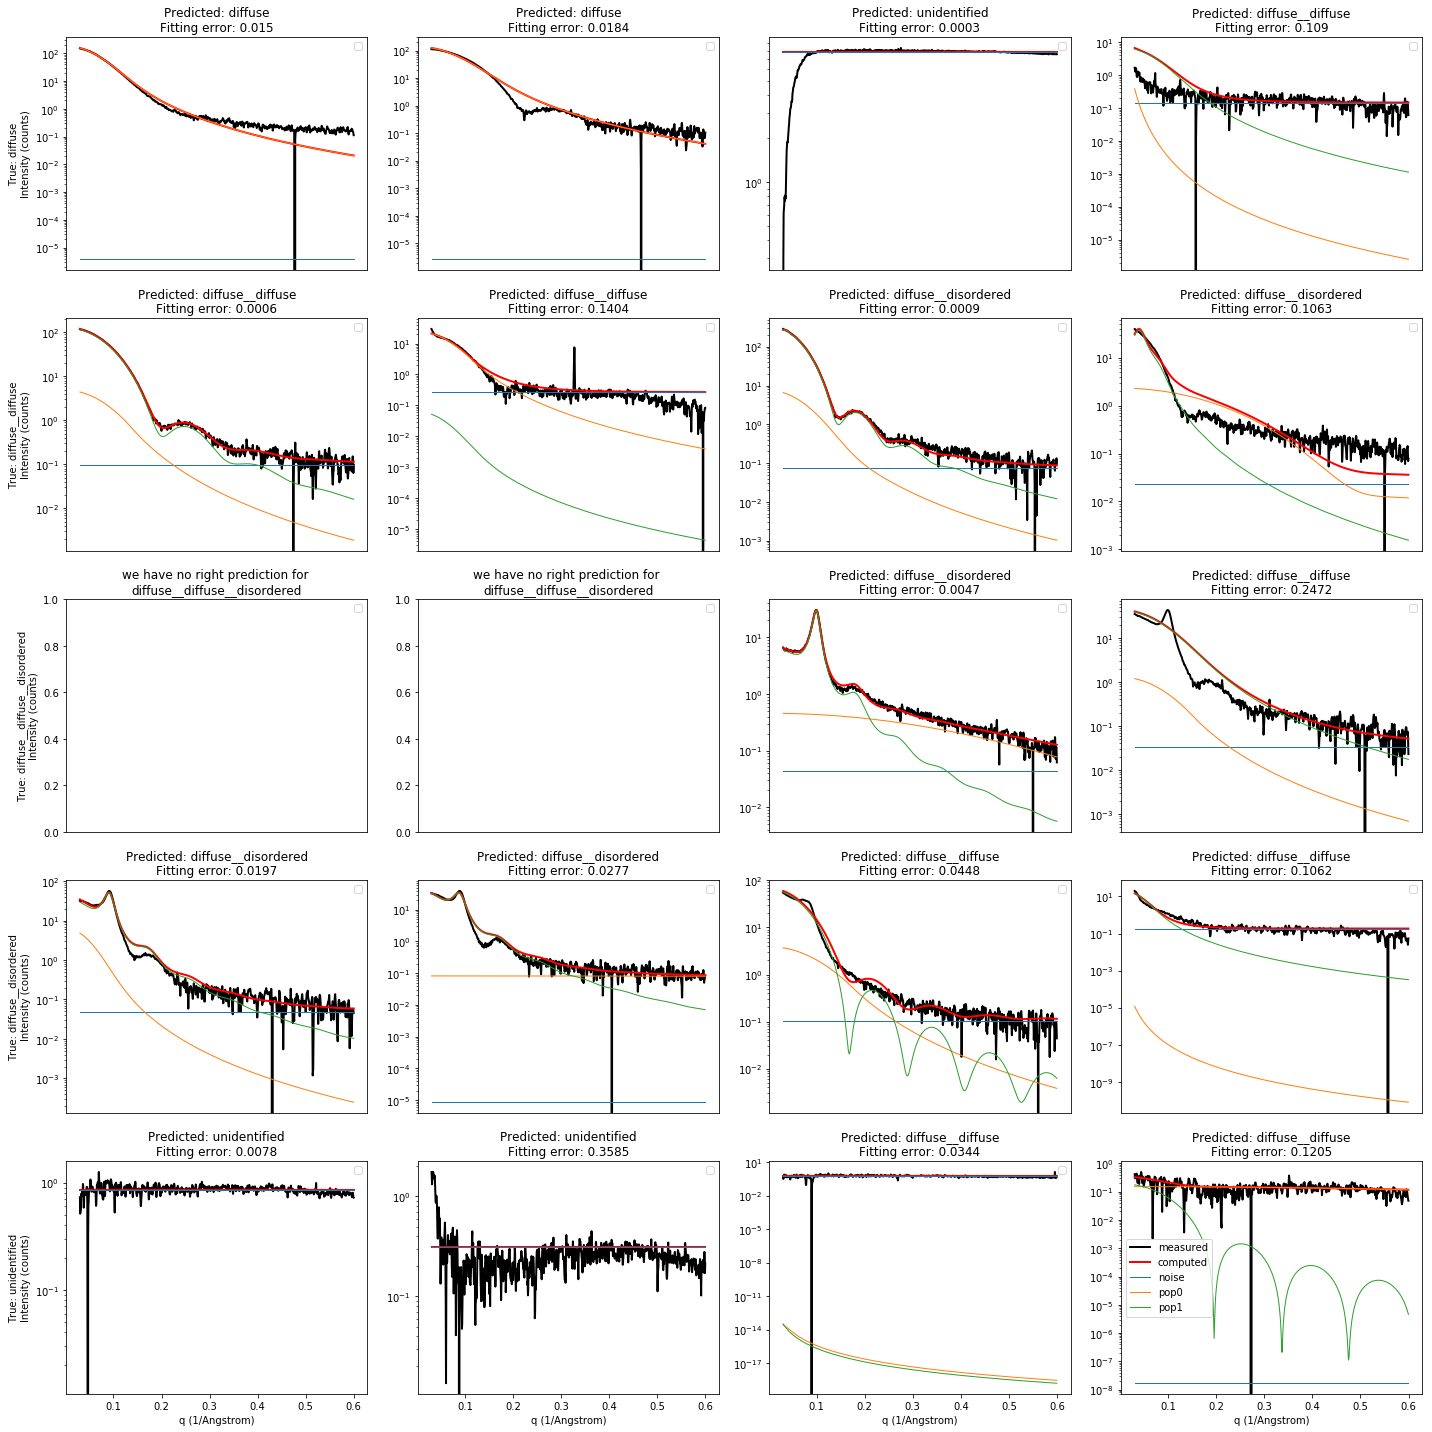

In [77]:
fig, ax = plt.subplots(5,4, figsize=(20,20))
ax = ax.flatten()
#fig.suptitle("Right Prediction     Wrong Prediction", fontsize=20)
grs = samples_to_vis.groupby(['system_class'])
i = 0
for n, g in grs:
    grs2 = g.groupby(['right_pred'])
    try:
        t = grs2.get_group(True)
        t = t.sort_values(by=['error'])
        for index, row in t.iterrows():
            q_I, sys = helper(row)
            _ = draw_xrsd_fit(ax[i],sys,q_I[:,0],q_I[:,1])
            ax[i].set_title(#"True: " +row['system_class'] + "\n" #+ row['form_factor'] +'\n'
                             "Predicted: "+ row['system_class_pr'] + "\n" #+ row['form_factor_pr'] + '\n'
                            + "Fitting error: " + str(round(row['error'], 4)))
            if i<16:
                x_axis = ax[i].axes.get_xaxis()
                x_axis.set_visible(False)
            if i%4 != 0:
                ax[i].set_ylabel('')
            else:
                ax[i].set_ylabel("True: " +row['system_class'] + "\n" + "Intensity (counts)")
            if i != len(ax)-1:
                ax[i].legend("")
            else:
                ax[i].legend("lower right")
            i+=1
    except: 
        for a in range(2):
            _ = draw_xrsd_fit(ax[i])
            ax[i].set_title("we have no right prediction for \n" + n)
            if i<16:
                x_axis = ax[i].axes.get_xaxis()
                x_axis.set_visible(False)
            if i%4 != 0:
                ax[i].set_ylabel('')
            else:
                ax[i].set_ylabel("True: " + n + "\n" + "Intensity (counts)")
            if i != len(ax)-1:
                ax[i].legend("")
            i+=1
    try:
        f = grs2.get_group(False)
        f = f.sort_values(by=['error'])
        for index, row in f.iterrows():
            q_I, sys = helper(row)
            _ = draw_xrsd_fit(ax[i],sys,q_I[:,0],q_I[:,1])
            ax[i].set_title(#"True: " +row['system_class'] + "\n"# + row['form_factor'] +'\n'
                             "Predicted: "+ row['system_class_pr'] + "\n" #+ row['form_factor_pr'] + '\n'
                            + "Fitting error: " + str(round(row['error'], 4)))
            if i<16:
                x_axis = ax[i].axes.get_xaxis()
                x_axis.set_visible(False)
            if i%4 != 0:
                ax[i].set_ylabel('')
            else:
                ax[i].set_ylabel("True: " +row['system_class'] + "\n" + "Intensity (counts)")
            if i != len(ax)-1:
                ax[i].legend("")
            i+=1
    except: 
        for a in range(2):
            _ = draw_xrsd_fit(ax[i])
            ax[i].set_title("we have no right prediction for \n" + n)
        if i<16:
            x_axis = ax[i].axes.get_xaxis()
            x_axis.set_visible(False)
        if i%4 != 0:
            ax[i].set_ylabel('')
        else:
                ax[i].set_ylabel("True: " + n + "\n" + "Intensity (counts)")
        if i != len(ax)-1:
                ax[i].legend("")
        i+=1
fig.tight_layout()   
plt.savefig("plots.png")